In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("gutenberg")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

Generate corpus using all the fileids present in gutenberg

In [ ]:
from nltk.corpus import gutenberg, stopwords
from nltk.tokenize import word_tokenize
import numpy as np

stopwords = set(stopwords.words('english'))

corpora = []
for file in gutenberg.fileids():
  raw_corpus = list(gutenberg.words(file))
  corpus = []
  for token in raw_corpus:
    token = token.lower()
    if(len(token)) == 1 and not token.isalnum():
      continue
    corpus.append(token)

  corpus = [word for word in corpus if word not in stopwords]
  corpora.append(corpus)


vocab = list(set(word for corpus in corpora for word in corpus))
index_word = {w: i for i, w in enumerate(vocab)}
len_vocab = len(vocab)
dimensions = 100

embed_in = np.random.randn(len_vocab, dimensions) * 0.01
embed_out = np.random.randn(len_vocab, dimensions) * 0.01

Define Sigmoid function

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

Generate text pairs with a sliding window of 5

In [ ]:
text_pairs=[]
sliding_window=5
for corpus in corpora:
  for i in range(len(corpus)):
    context=[]
    for j in range(max(0, i-sliding_window), min(len(corpus), i+sliding_window + 1)):
        if(i!=j):
            context.append(corpus[j])
    text_pairs.append([context, corpus[i]])


Generate 5 negative samples for each center word

In [ ]:
def gen_neg_samp(index_word, neg_samples = 5):
    negatives = []
    while(len(negatives)) < neg_samples:
        temp = random.randint(0, len_vocab - 1)
        if temp != index_word:
            negatives.append(temp)
    return negatives

Actual Training process happens here

In [ ]:
import numpy as np

def train_skipgram(context_words, center_word, lr=0.01):
    index_contexts = [index_word[word] for word in context_words]
    index_center = index_word[center_word]
    center_update = np.zeros(100)

    for index_context in index_contexts:
        temp = lr*(sigmoid(np.dot(embed_in[index_center], embed_out[index_context])) - 1)

        center_update += temp*embed_out[index_context]
        embed_out[index_context] -= temp*embed_in[index_center]

    for index_negative in gen_neg_samp(index_center):
        temp = lr*(sigmoid(np.dot(embed_in[index_center], embed_out[index_negative])))

        center_update += embed_out[index_negative] * temp
        embed_out[index_negative] -= embed_in[index_center] * temp

    embed_in[index_center] -= center_update

In [ ]:
import random

for epoch in range(2000000):
    context_words , center_word = random.choice(text_pairs)
    train_skipgram(context_words, center_word)

In [ ]:
def embedding(word):
    return embed_in[index_word[word]]

def cosine(a, b):
    return np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))

Sub-Task 1

In [ ]:
from collections import Counter

freq = Counter(corpus)
freq = freq.most_common(200)
wordlist = [word for word, i in freq]

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

word_vectors = np.array([embedding(word) for word in wordlist])

pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

df = pd.DataFrame(result, columns=['x', 'y'])
df['word'] = wordlist

fig = px.scatter(df, x='x', y='y', text='word')
fig.show()


Sub-Task 2

In [ ]:
queen_check = embedding("king") - embedding("man") + embedding("woman")
print(cosine(queen_check, embedding("queen")))

0.990436240765318


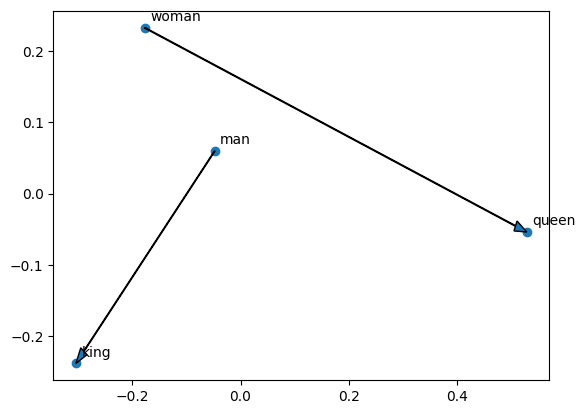

In [ ]:
words = ["man", "king", "woman", "queen"]
plot_vec = np.array([embedding(word) for word in words])

plot_vec = PCA(n_components=2).fit_transform(plot_vec)
plt.scatter(plot_vec[:, 0], plot_vec[:, 1])

for i, word in enumerate(words):
  plt.text(plot_vec[i, 0]+0.01, plot_vec[i, 1]+0.01, word)

plt.arrow(plot_vec[0, 0], plot_vec[0,1], plot_vec[1,0] - plot_vec[0,0], plot_vec[1,1] - plot_vec[0,1], length_includes_head = True, head_width = 0.015)
plt.arrow(plot_vec[2, 0], plot_vec[2,1], plot_vec[3,0] - plot_vec[2,0], plot_vec[3,1] - plot_vec[2,1], length_includes_head = True, head_width = 0.015)

plt.show()